### Paxillin movie segmentation and object feature analysis

with Annabel's movies, but data seems not as expected. So use this as the dev for cell mask features

Liya Ding, 2024.03

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
from tifffile import imread
from tifffile import imsave
import czifile
from skimage.morphology import remove_small_objects
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
from scipy.ndimage import gaussian_filter
from joblib import dump, load

from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
import umap

# function from aicssegmentation tool
from utils.vessel_2d import filament_2d_wrapper
from utils.pre_processing_utils import intensity_normalization


In [2]:
czi_dir =  '/mnt/d/lding/UbuntuGitCodes/focal_adhesion_clustering/data'
plot_output_dir = '/mnt/d/lding/UbuntuGitCodes/focal_adhesion_clustering/FA_plot'
seg_output_dir = '/mnt/d/lding/UbuntuGitCodes/focal_adhesion_clustering/FA_seg'

if not os.path.isdir(plot_output_dir):
    os.makedirs(plot_output_dir)

if not os.path.isdir(seg_output_dir):
    os.makedirs(seg_output_dir)

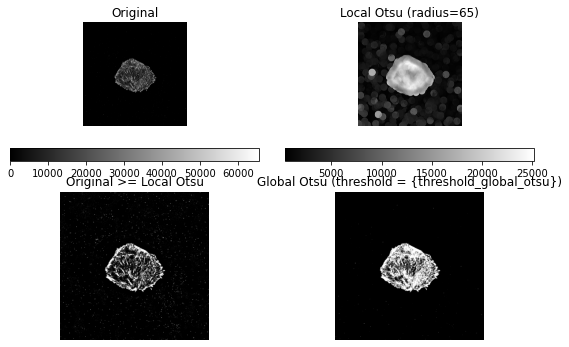

In [51]:
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt

from skimage import data
from skimage.filters import try_all_threshold

from skimage.morphology import ball

img = input_pax_img.squeeze()

radius = 65
footprint = disk(radius)

local_otsu = rank.otsu(img, footprint)
threshold_global_otsu = threshold_otsu(img)
global_otsu = img >= threshold_global_otsu

fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey=True)
ax = axes.ravel()
plt.tight_layout()

fig.colorbar(ax[0].imshow(img, cmap=plt.cm.gray),
             ax=ax[0], orientation='horizontal')
ax[0].set_title('Original')
ax[0].axis('off')

fig.colorbar(ax[1].imshow(local_otsu, cmap=plt.cm.gray),
             ax=ax[1], orientation='horizontal')
ax[1].set_title(f'Local Otsu (radius={radius})')
ax[1].axis('off')

ax[2].imshow(img >= local_otsu, cmap=plt.cm.gray)
ax[2].set_title('Original >= Local Otsu')
ax[2].axis('off')

ax[3].imshow(global_otsu, cmap=plt.cm.gray)
ax[3].set_title('Global Otsu (threshold = {threshold_global_otsu})')
ax[3].axis('off')

plt.show()

In [6]:
img.shape

(191, 384)

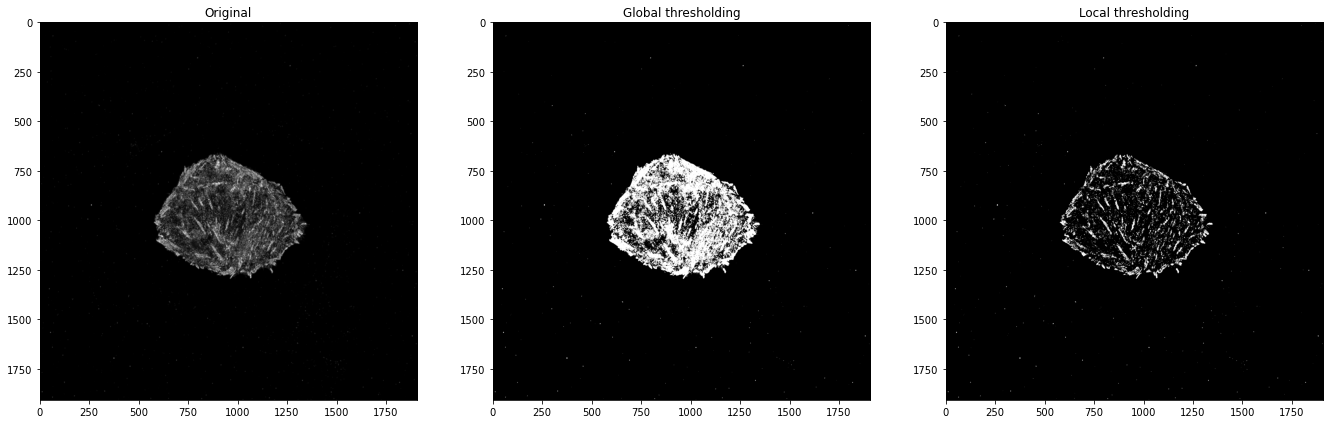

In [46]:
from skimage.filters import threshold_otsu, threshold_local

input_actin = struct_img0[2,5,:,:]
input_pax_img = struct_img0[0,5,:,:]

image = input_pax_img

global_thresh = threshold_otsu(image)
binary_global = input_pax_img > global_thresh

block_size = 101
local_thresh = threshold_local(image, block_size, offset=0)
binary_local = (input_pax_img - local_thresh)>10000


fig, axes = plt.subplots(ncols=3, figsize=(23, 12))
ax = axes.ravel()
plt.gray()

ax[0].imshow(image)
ax[0].set_title('Original')

ax[1].imshow(binary_global)
ax[1].set_title('Global thresholding')

ax[2].imshow(binary_local)
ax[2].set_title('Local thresholding')

for a in ax:
    a.axis('on')
    
plt.show()

### mkdir related dir


### for the exp, run through all cells

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


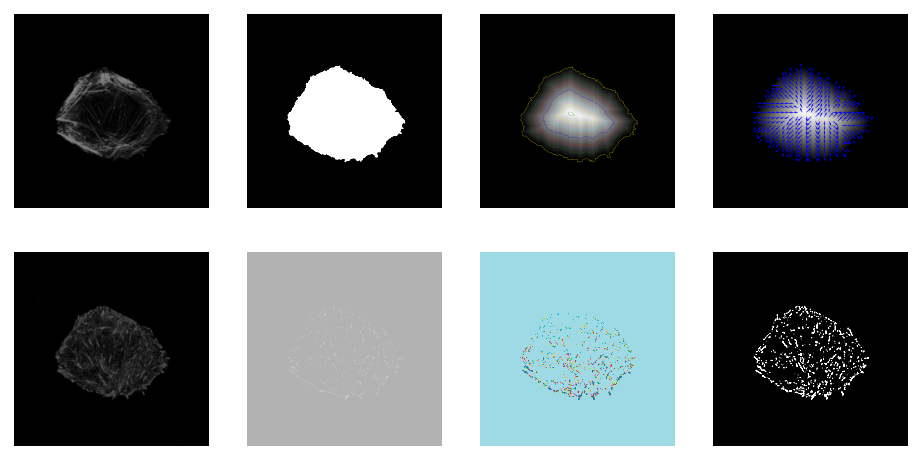

In [149]:
prop_df_pax = pd.DataFrame(columns=['cell_ID','time_point','area', 'bbox_area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number',
                                'extent','filled_area','label','major_axis_length','max_intensity','mean_intensity',
                                'min_intensity','minor_axis_length','orientation','perimeter','solidity'])

filenames = [x for x in os.listdir(czi_dir) if os.path.isfile(os.path.join(czi_dir, x)) and ('.czi' in x)]

for filename in filenames[0:1]:
    img = czifile.imread(os.path.join(czi_dir,filename))
    struct_img0 = img[0,0,:,:,:,:,0] 

    input_actin_img = struct_img0[2,5,300:-300,300:-300]
    input_pax_img = struct_img0[0,5,300:-300,300:-300]

    ### intensity normalization
    intensity_scaling_param = [5,20]
    norm_actin_img = intensity_normalization(input_actin_img, scaling_param=intensity_scaling_param)
    norm_pax_img = intensity_normalization(input_pax_img, scaling_param=intensity_scaling_param)

    # smoothing with edge preserving smoothing 
    smooth_actin_img = gaussian_filter(norm_actin_img,sigma=1,mode='nearest',truncate=3)
    smooth_pax_img = gaussian_filter(norm_pax_img,sigma=1,mode='nearest',truncate=3)

    new_cell_mask = smooth_actin_img>0.02
    new_cell_mask = remove_small_objects(new_cell_mask>0, min_size=200, connectivity=1, in_place=False)
    from scipy import ndimage
    new_cell_mask = ndimage.binary_fill_holes(new_cell_mask)
    from scipy.ndimage import distance_transform_cdt
    distance_taxicab = distance_transform_cdt(new_cell_mask, metric="taxicab")
    
    ## PARAMETERS for vesselness filter step ##
    f2_param = [[1, 0.95]]
    pax_seg = filament_2d_wrapper(smooth_pax_img, f2_param)

    pax_seg = pax_seg*new_cell_mask
    pax_seg = remove_small_objects(pax_seg>0, min_size=2, connectivity=1, in_place=False)


    label_pax_seg = label(pax_seg*new_cell_mask)
    regionprops_pax = regionprops(label_pax_seg,intensity_image=input_pax_img)

        
    imsave(os.path.join(plot_output_dir, 'cell_mask_'+filename[:-4] +'.tif'),new_cell_mask.astype(np.uint8))   
    imsave(os.path.join(plot_output_dir, 'pax_seg_'+filename[:-4] +'.tif'),pax_seg.astype(np.uint8))   
    imsave(os.path.join(plot_output_dir, 'pax_seglabel_'+filename[:-4] +'.tif'),label_pax_seg.astype(np.uint16))   
    imsave(os.path.join(plot_output_dir, 'pax_segrgb_'+filename[:-4] +'.tif'),pax_image_label_overlay.astype(np.uint8))   
            

    pax_image_label_overlay = label2rgb(label_pax_seg, image=smooth_pax_img*0+0.2, bg_label=0)
       
    fig, ax = plt.subplots(2, 4, figsize=(8,4), dpi=144, facecolor='w', edgecolor='k')
    ax[0,0].imshow(norm_actin_img, cmap=plt.cm.gray,vmax=2,vmin=0)
    ax[0,0].axis('off')
    ax[0,1].imshow(new_cell_mask, cmap=plt.cm.gray,vmax=0.3,vmin=0)
    ax[0,1].axis('off')
    X, Y = np.meshgrid(np.arange(0,new_cell_mask.shape[0]), np.arange(0,new_cell_mask.shape[1]))
    ax[0,2].imshow(distance_taxicab)
    ax[0,2].contour(X, Y, distance_taxicab,6,colors=('yellow','green', 'r','blue','cyan'),linewidths=0.1)
    ax[0,2].axis('off')
    import skimage
    n_v = skimage.filters.sobel_v(distance_taxicab)
    n_h = skimage.filters.sobel_h(distance_taxicab)
    for_plot_max = 5/min(n_v.max(), n_h.max())
    n_v = n_v*for_plot_max
    n_h = n_h*for_plot_max
    
    grid_mask = np.zeros_like(new_cell_mask)
    grid_mask[::30,::30] = new_cell_mask[::30,::30]
    to_plot_X = X[grid_mask>0]
    to_plot_Y = Y[grid_mask>0]
    to_plot_U = n_v[grid_mask>0]
    to_plot_H = n_h[grid_mask>0]

    # ax[0,3].imshow(n_v, cmap=plt.cm.gray,vmax=0.1,vmin=0)
    ax[0,3].imshow(distance_taxicab)
    ax[0,3].quiver(to_plot_X,to_plot_Y, -to_plot_U,to_plot_H,color='blue')
    ax[0,3].contour(X, Y, distance_taxicab,6,linewidths=0.1)    
    ax[0,3].axis('off')

    ax[1,0].imshow(norm_pax_img, cmap=plt.cm.gray,vmax=2,vmin=0)
    ax[1,0].axis('off')
    ax[1,1].imshow(pax_image_label_overlay*5, cmap=plt.cm.RdBu_r,vmax=0.1,vmin=0)
    ax[1,1].axis('off')
    ax[1,2].imshow(label_pax_seg, cmap=plt.cm.tab20_r,vmax=100,vmin=1)
    ax[1,2].axis('off')
    ax[1,3].imshow(pax_seg, cmap=plt.cm.gray,vmax=0.1,vmin=0)
    
    ax[1,3].axis('off')

        

In [142]:
regionprops_pax[0]['orientation']


-0.06084889101154799

(-0.5, 1307.5, 1307.5, -0.5)

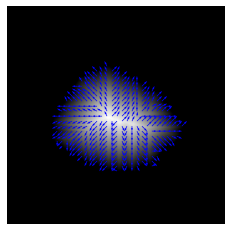

In [139]:
plt.imshow(distance_taxicab)


grid_mask = np.zeros_like(new_cell_mask)
grid_mask[::30,::30] = new_cell_mask[::30,::30]
to_plot_X = X[grid_mask>0]
to_plot_Y = Y[grid_mask>0]
to_plot_U = n_v[grid_mask>0]
to_plot_H = n_h[grid_mask>0]

# plt.contour(X, Y, distance_taxicab,6,linewidths=2)    
plt.quiver(to_plot_X,to_plot_Y, -to_plot_U,to_plot_H,color='blue')
plt.axis('off')

In [122]:
to_plot_X = X[new_cell_mask>0]
to_plot_Y = Y[new_cell_mask>0]
to_plot_U = n_v[new_cell_mask>0]
to_plot_H = n_h[new_cell_mask>0]

In [123]:
to_plot_X.shape

(329809,)